In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.measurement as mse
import pylib.qsvt_angles as qsvt_a
import cvxpy as cp

11829
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------
def reproduce_even(x, coefs):
    Nx = len(x)
    res_pol = np.zeros(Nx)
    for ix in range(Nx):
        res_pol[ix] = 0.
        for ii in range(Nc_):
            res_pol[ix] += coefs[ii] * np.cos((2*ii) * np.arccos(x[ix]))
    return res_pol


def test_even_Ch(x, coefs):
    res_pol = 0.
    for ii in range(Nc_):
        res_pol += coefs[ii] * np.cos((2*ii) * np.arccos(x))
    return res_pol


# ---------------------------------------------------------------------------
def reproduce_odd(x, coefs):
    Nx = len(x)
    res_pol = np.zeros(Nx)
    for ix in range(Nx):
        res_pol[ix] = 0.
        for ii in range(Nc_):
            res_pol[ix] += coefs[ii] * np.cos((2*ii+1) * np.arccos(x[ix]))
    return res_pol


def test_odd_Ch(x, coefs):
    res_pol = 0.
    for ii in range(Nc_):
        res_pol += coefs[ii] * np.cos((2*ii+1) * np.arccos(x))
    return res_pol

In [13]:
# ---------------------------------------------------
# --- Functions to approximate ---
# ---------------------------------------------------
def func_xG(x):
    Nx = len(x)
    y = np.zeros(Nx)
    for ii in range(Nx):
        y[ii] = -x[ii] * np.exp(-x[ii]**2/(2.*par_**2))
    return y

def func_inv(x):
    Nx = len(x)
    y = np.zeros(Nx)
    for ii in range(Nx):
        y[ii] = ( 1. - np.exp(-(5*par_*x[ii])**2) ) / x[ii]
    y *= 1.0/par_
    return y

def func_acos(x):
    Nx = len(x)
    y = np.zeros(Nx)
    for ii in range(Nx):
        y[ii] = np.arccos(x[ii])/np.pi - 0.5
    return y

In [17]:
# ---------------------------------------------------
# --- Choose the function to approximate ---
# ---------------------------------------------------

# --- Where to save ---
# path_root_ ="./tools/QSVT-angles/inversion/coefs/"
path_root_ ="./tools/QSVT-angles/acos/coefs/"

# --- Choose the function to approximate ---
id_fun = 2 # chosen function;
par_   = 10. # function parameter;

# --- Choose the function to approximate using the predefined index id_fun ---
func_ch_ = None
parity_  = None
line_f_ = None

if id_fun == 0:
    coef_norm_ = 1.0
    func_ch_ = func_xG
    parity_ = 1
    line_f_ = "xG"
    
if id_fun == 1:
    coef_norm_ = 0.125
    func_ch_ = func_inv
    parity_ = 1
    line_f_ = "inv"
    
if id_fun == 2:
    coef_norm_ = 1.0
    func_ch_ = func_acos
    parity_ = 1
    line_f_ = "arccos"

# --- Take the test and reconstruction functions appropriate to the chosen parity ---
test_func_ = None
rec_func_ = None
if parity_ == 0:
    test_func_ = test_even_Ch
    rec_func_  = reproduce_even
else:
    test_func_ = test_odd_Ch
    rec_func_  = reproduce_odd
    
# --- Print the chosen parameters and functions ---
print("Function parameter:\t\t {:0.3e}".format(par_))
print("Chosen function, parity:\t {:s}, {:d}".format(line_f_, parity_))

# --- Remove some variables ---
del id_fun

Function parameter:		 1.000e+01
Chosen function, parity:	 arccos, 1


In [18]:
# -----------------------------------------------------------------
# --- Approximate the chosen function ---
# -----------------------------------------------------------------

# Nd_ = int(900/40. * 5) # polynomial order;
Nd_ = int(300/5. * 10) # polynomial order;

Nc_ = Nd_ // 2 # number of coefficients;
Nx_ = Nd_*4;

# --- x-grid ---
x_ = np.zeros(Nx_)
for ii in range(Nx_):
    x_[ii] = np.cos((2*ii + 1)*np.pi / (2.*Nx_));
    
# --- Evaluate the chosen function ---
y_ref_ = func_ch_(x_)
y_ref_ *= coef_norm_

# --- Estimate the coefficients ---
coefs_ = cp.Variable(Nc_)
objective = cp.Minimize(cp.sum_squares(test_func_(x_,coefs_) - y_ref_))
prob = cp.Problem(objective)
result = prob.solve()

# --- reconstruct the function ---
y_rec_ = rec_func_(x_, coefs_.value)

# --- compute the maximum absolute error of the approximation ---
max_abs_err_ = np.max(np.abs(y_rec_ - y_ref_))

print("Chosen polynomial's degree:\t {:d}".format(Nd_))
print("Number of coefficients:\t\t {:d}".format(Nc_))
print("max. abs. error: {:0.3e}".format(max_abs_err_))

Chosen polynomial's degree:	 600
Number of coefficients:		 300
max. abs. error: 1.639e-04


parameter: 1.000e+01


<IPython.core.display.Javascript object>


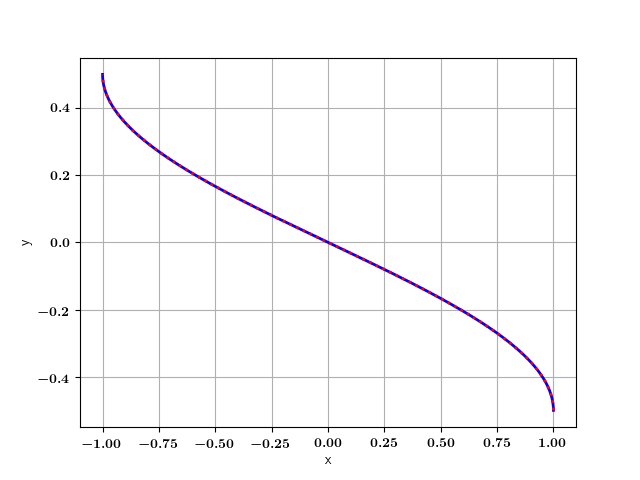

In [19]:
# -----------------------------------------------------------------
# --- Plot the reconstructed function ---
# -----------------------------------------------------------------
print("parameter: {:0.3e}".format(par_))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_, y_ref_, color="b", linewidth = 2, linestyle='-', label = "ref")
ax.plot(x_, y_rec_,  color="r", linewidth = 2, linestyle=':', label = "reco")
plt.xlabel('x')
plt.ylabel("y")
# plt.xlim(-5, 5)
plt.grid(True)
plt.show()

In [20]:
# -----------------------------------------------------------------
# --- Store the coefficients into the .hdf5 file ---
# -----------------------------------------------------------------
from datetime import datetime
from datetime import date

# --- Current time ---
curr_time = date.today().strftime("%m/%d/%Y") + ": " + datetime.now().strftime("%H:%M:%S")

# --- Create the filename ---
fname_ = "{:s}_{:d}_{:d}.hdf5".format(line_f_, int(par_), -int(np.log10(max_abs_err_)))
full_fname = path_root_ + "/" + fname_

# --- Store data ---
print("write angles to:\n " + full_fname)
with h5py.File(full_fname, "w") as f:
    grp = f.create_group("basic")
    grp.create_dataset('coef_norm',           data=float(coef_norm_))
    grp.create_dataset('date-of-simulation',  data=curr_time)
    grp.create_dataset('descr',  data=line_f_)
    grp.create_dataset('eps',    data=float(max_abs_err_))
    grp.create_dataset('param',  data=float(par_))
    grp.create_dataset('parity', data=parity_)

    grp = f.create_group("coefs")
    grp.create_dataset('real',  data = coefs_.value)
    
del full_fname

write angles to:
 ./tools/QSVT-angles/acos/coefs//arccos_10_3.hdf5
